<center>
    <h1> Clasificación de eventos y explicación con SHAP </h2>
</center>

## Contenidos

* [Introducción](#Introducción)
* [Bibliotecas](#Bibliotecas)
* [Datos](#Datos)
* [Modelo Caja Negra](#Modelo-Caja-Negra)
* [KernelExplainer](#KernelExplainer)
* [Ejercicio](#Ejercicio)

## Introducción

En el siguiente notebook, se ejemplifica el uso de SHAP para explicar un modelo de red neuronal que clasifica eventos de **HEP** (High Energy Physics) en dos clases: *signal* y *background*.

Como se puede ver en la imagen, tanto la señal como el *background* corresponden a eventos que decaen en dos bosones $W$ y dos quarks $b$. La diferencia yace en que la señal involucra los bosones de Higgs $H^0$ y $H^{\pm}$.

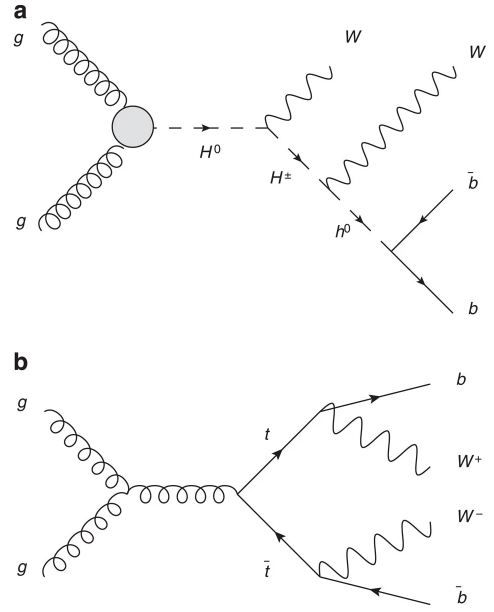
<p align="center">
  <i>Imagen obtenida desde <a href="https://www.nature.com/articles/ncomms5308/figures/1">Baldi et al (2014)</a></i>
</p>



## Bibliotecas

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#!pip install shap
!pip install mplhep

In [7]:
import shap
import keras
import numpy as np
import pandas as pd
import mplhep as hep
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, accuracy_score, f1_score

In [8]:
shap.initjs()

## Datos

El conjunto de datos es público y la fuente de los datos está en el siguiente [link](https://www.openml.org/d/23512).

Cada evento es representado por un conjunto de 28 variables.

21 variables son de bajo nivel y corresponden a propiedades físicas medidas mediante un detector.

7 variables son de alto nivel, y por ende, derivadas a partir de las variables de bajo nivel.

<table style="margin: 0 auto;">
  <thead>
    <tr>
      <th>Type</th>
      <th>Variable</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>low-level</td>
      <td>lepton pT</td>
      <td>Momentum of the lepton</td>
    </tr>
    <tr>
      <td>low-level</td>
      <td>lepton eta</td>
      <td>Pseudorapidity eta of the lepton</td>
    </tr>
    <tr>
      <td>low-level</td>
      <td>lepton phi</td>
      <td>Azimuthal angle phi of the lepton</td>
    </tr>
    <tr>
      <td>low-level</td>
      <td>Missing energy magnitude</td>
      <td>Energy not detected</td>
    </tr>
    <tr>
      <td colspan="3">...</td>  </tr>
    <tr>
      <td>high-level</td>
      <td>m_jlv</td>
      <td>Mass jet ($j$), lepton ($l$, electrons or muons), neutrino $\nu$</td>
    </tr>
    <tr>
      <td>high-level</td>
      <td>m_bb</td>
      <td>Mass quarks $b$</td>
    </tr>
    <tr>
      <td>high-level</td>
      <td>m_wbb</td>
      <td>Mass boson $W$ and quarks $b$</td>
    </tr>
    <tr>
      <td>high-level</td>
      <td>m_wwbb</td>
      <td>Mass bosons $W$ and quarks $b$</td>
    </tr>
  </tbody>
</table>


In [ ]:
!gdown https://drive.google.com/uc?id=1qVaxHa5SyGU5zD8JBD2gaBIQj28ev9Va

df = pd.read_csv("higgs_bb.csv", skipfooter=1, engine='python')

In [10]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, shuffle=True, test_size=0.2, random_state=0
)

## Modelo Caja Negra

El modelo a explicar se encuentra entrenado y se debe descargar desde el siguiente [Drive](https://drive.google.com/drive/folders/1RP9mYlGoEXCaR0XemMH5LwWue8_buPpF?usp=sharing).

In [ ]:

!gdown https://drive.google.com/uc?id=1hq7dXYxuaimkSPg2BRjQ1dZYHWqQHVEx

model_name = "DNN_model.h5"
model = keras.models.load_model(model_name)

El modelo produce una salida en el rango [0,1], donde valores cercanos a 1 indican eventos de señal y valores cercanos a 0 indican eventos de *background*.

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

In [ ]:
f, axs = plt.subplots(1, 1, sharex=True, sharey=True)
h_signal_train, bins_sig_train = np.histogram(y_pred_train[y_train == 1], bins=30)
h_back_train, bins_back_train = np.histogram(y_pred_train[y_train == 0], bins=30)
h_sig_test, bins_sig_test = np.histogram(y_pred_test[y_test == 1], bins=30)
h_back_test, bins_back_test = np.histogram(y_pred_test[y_test == 0], bins=30)

axs.set_title("Distribución de predicciones", fontsize=14)
hep.histplot(
    [h_signal_train, h_back_train, h_sig_test, h_back_test],
    bins_sig_test,
    ax=axs,
    label=["Train-Sig", "Train-B", "Test-S", "Test-B"],
)
axs.legend(fontsize=16)
axs.set_xlabel("Predicción")
axs.set_ylabel("Número de eventos")

plt.tight_layout()
plt.show()

In [ ]:
y_pred = y_pred_test > 0.5

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
auc_score = auc(fpr, tpr)
metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC": auc_score
}

for metric_name, metric_value in metrics.items():
    print(f"{metric_name}: {metric_value:.2f}")

In [ ]:
plt.plot(fpr,tpr, label=f"Curva ROC (area = {auc_score:.2f})")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()
plt.grid()
plt.show()

## KernelExplainer

In [16]:
n = 100 # puede tardar mucho con este número

In [ ]:
explainer = shap.KernelExplainer(model.predict, X_test.iloc[:n])
shap_values = explainer(X_test[:n])



In [19]:
shap_values.values = shap_values.values.squeeze()

### Watefall plot

* El [shap.plots.waterfall](https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/waterfall.html) muestra la explicación de la predicción de una instancia específica.
* La parte inferior de un gráfico de cascada comienza con el valor esperado del resultado del modelo, y luego cada fila muestra cómo la contribución positiva (roja) o negativa (azul) de cada variable que define a la instancia mueve el valor del resultado esperado del modelo

In [ ]:
instance_idx = 0 # Should be less than n
shap.plots.waterfall(shap_values[instance_idx])

### Force plot

El [gráfico de fuerza](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Force%20Plot%20Colors.html) es otra forma de visualizar la contribución de cada variable en la predicción generada por el modelo


In [ ]:
instance_idx = 0 # Should be less than n
shap.plots.force(shap_values[instance_idx])

### Summary Plot

* Muestra un resumen de como las variables de un conjunto de datos afecta en salida del modelo.
* Cada punto del gráfico es una instancia
* La posición del punto en el eje $x$ está determimada por su el valor SHAP
* Los puntos se van "apilando" a lo largo de cada fila de variables
* El color se usa para mostrar el valor original de una característica
* Por ejemplo, en este gráfico se ve que la variable que más contribuye en promedio es m_bb.


In [ ]:
shap.summary_plot(shap_values, X_test[:n])

### Ranking de variables

* El summary plot también se puede mostrar con barras, lo que entrega un *ranking* de variables
* Este ranking nos entrega una **explicación global** y se construye calculando un índice de importance $I_j$ de la variable $j$, considerando el promedio de los valores absolutos de los valores SHAP por cada variable y para todo el conjunto de datos:
$$I_j = \frac{1}{n}\sum_{i=1}^{n}|\phi_{j}^{(i)}|$$

donde $j$ es el índice asociado a la variable y $n$ representa el número de variables que definen a los datos

In [ ]:
shap.summary_plot(shap_values, X_test[:n], plot_type="bar")

### Dependence plot

* Este gráfico de [dependencia](https://shap-lrjball.readthedocs.io/en/latest/generated/shap.dependence_plot.html), también nos entrega una explicación global.
* Este gráfico muestra el valor de la variable en el eje $x$ y el valor SHAP en el eje $y$
* Se visualiza cómo el modelo depende se comporta para la variable indicada
* La dispersión vertical de los puntos de datos representa efectos de interacción.
* El color de los puntos va asociado a la variable con la que tiene mayor *interacción*.

In [ ]:
shap.dependence_plot("m_wbb", shap_values.values, X_test[:n])

## Ejercicio

* Probar explicaciones para otros eventos.
* Usar <a href="https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/decision_plot.html">decision plot</a>  e indicar que permite explicar.
</li>